In [48]:
!pip install kagglehub openpyxl imbalanced-learn seaborn -q

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

/opt/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#downloading the dataset from kaggle
path = kagglehub.dataset_download("sidsriram62067/data-set-for-upi-fraud")

file_path = glob.glob(os.path.join(path, "*.xlsx"))

df = pd.read_excel(file_path[0])
df.head()

,trans_hour,trans_day,trans_month,trans_year,category,upi_number,age,trans_amount,state,zip,fraud_risk
0,23,5,3,2022,11,14755226,22,128.45,10,34211,0
1,2,1,8,2022,0,9777695,79,55.31,43,99191,0
2,17,23,2,2022,10,10599380,40,115.76,21,36895,0
3,0,10,3,2022,10,16218941,38,113.38,39,20348,0
4,0,27,8,2022,1,12644707,72,268.73,20,10136,0


In [4]:
df.describe()

,trans_hour,trans_day,trans_month,trans_year,category,upi_number,age,trans_amount,state,zip,fraud_risk
count,500000.000000,500000.000000,500000.000000,500000.0,500000.000000,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,10.901728,15.709540,5.211722,2022.0,5.618178,8.391358e+06,52.973040,94.622925,24.473764,49866.391554,0.159000
std,7.765241,7.920126,3.590702,0.0,3.487478,4.843072e+06,18.941509,69.163927,14.402148,25630.392114,0.365676
min,0.000000,1.000000,1.000000,2022.0,0.000000,1.010000e+02,18.000000,-49.180000,0.000000,10136.000000,0.000000
25%,3.000000,9.000000,2.000000,2022.0,2.000000,4.194184e+06,37.000000,44.950000,12.000000,28705.000000,0.000000
50%,12.000000,16.000000,5.000000,2022.0,6.000000,8.385041e+06,52.000000,90.170000,24.000000,48845.000000,0.000000
75%,18.000000,22.000000,8.000000,2022.0,9.000000,1.258572e+07,71.000000,138.980000,37.000000,69258.000000,0.000000
max,23.000000,28.000000,12.000000,2022.0,11.000000,1.677719e+07,79.000000,285.390000,49.000000,99791.000000,1.000000


In [ ]:
#lisr of transactiions with fraud_risk = 1
df_=df[df['fraud_risk']==1]
df_

,trans_hour,trans_day,trans_month,trans_year,category,upi_number,age,trans_amount,state,zip,fraud_risk
6,3,3,9,2022,0,9247721,47,40.57,2,32767,1
7,4,16,2,2022,10,10444032,79,92.45,49,57377,1
8,3,9,2,2022,11,8136375,79,13.04,4,35457,1
11,17,21,4,2022,8,1885234,37,57.68,46,66353,1
14,23,18,6,2022,11,15822641,71,285.39,35,17098,1
...,...,...,...,...,...,...,...,...,...,...,...
499960,17,1,6,2022,8,1438418,53,61.82,33,27339,1
499962,6,4,6,2022,4,7225777,41,171.72,21,79361,1
499966,0,20,10,2022,2,14178773,35,35.99,14,10136,1
499982,0,28,2,2022,4,8321465,29,36.52,16,80080,1


In [11]:
df.isnull().count()

trans_hour      500000
trans_day       500000
trans_month     500000
trans_year      500000
category        500000
upi_number      500000
age             500000
trans_amount    500000
state           500000
zip             500000
fraud_risk      500000
dtype: int64

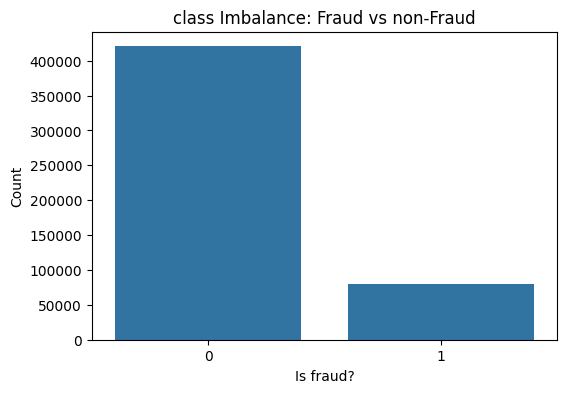

In [12]:
#comparision between number of fraud and non-fraud payments
target_col = df['fraud_risk']

plt.figure(figsize=(6, 4))
sb.countplot(x = target_col, data=df)
plt.title('class Imbalance: Fraud vs non-Fraud')
plt.xlabel('Is fraud?')
plt.ylabel('Count')
plt.show()

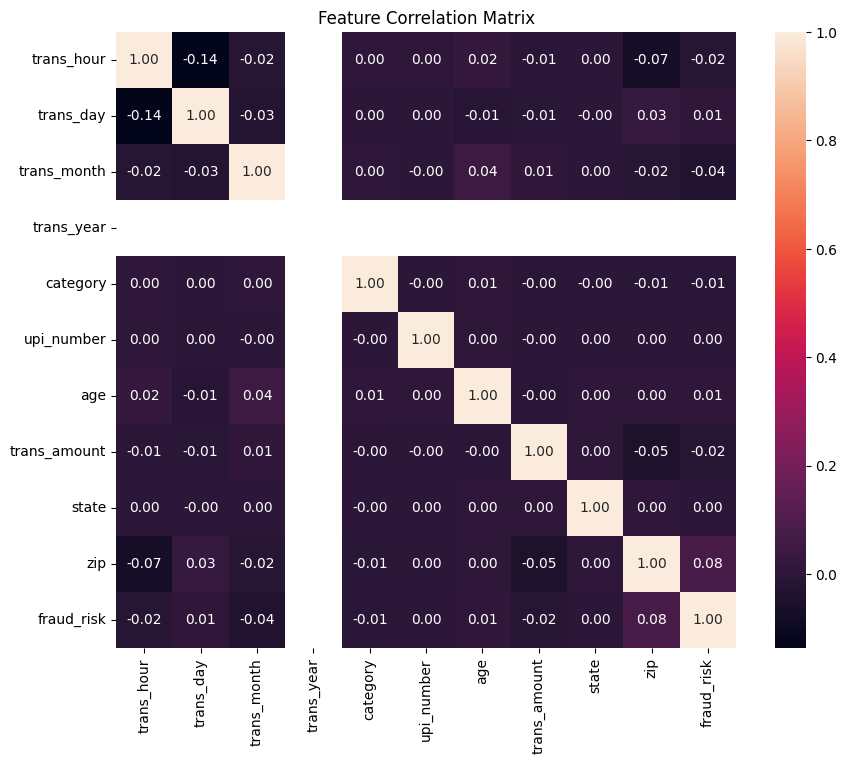

In [13]:
#Feature correlation matrix
plt.figure(figsize=(10, 8))

df_num= df.select_dtypes(include=[np.number])
sb.heatmap(df_num.corr(), annot=True, fmt = '.2f')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
#from the above graph, we can observe that fraud_risk is quite 
#random but a bit more concentrated in some zipcodes(0.08 is correlation between them)

In [14]:
#Defining upper bound for transaction amount.
quart1 = df['trans_amount'].quantile(0.25)
quart2 = df['trans_amount'].quantile(0.75)
IQR = quart2 - quart1
upper = quart2 + 2 * IQR
df['trans_amount'] = np.where(df['trans_amount'] > upper, upper, df['trans_amount'])

In [15]:
label = LabelEncoder()
object_cols = df.select_dtypes(include=['object']).columns

df

,trans_hour,trans_day,trans_month,trans_year,category,upi_number,age,trans_amount,state,zip,fraud_risk
0,23,5,3,2022,11,14755226,22,128.45,10,34211,0
1,2,1,8,2022,0,9777695,79,55.31,43,99191,0
2,17,23,2,2022,10,10599380,40,115.76,21,36895,0
3,0,10,3,2022,10,16218941,38,113.38,39,20348,0
4,0,27,8,2022,1,12644707,72,268.73,20,10136,0
...,...,...,...,...,...,...,...,...,...,...,...
499995,9,1,10,2022,7,13884364,73,11.94,2,61658,0
499996,0,18,4,2022,8,2303368,74,44.82,7,41833,0
499997,13,23,1,2022,10,9796364,41,166.79,48,15614,0
499998,0,4,1,2022,1,8335132,42,166.54,31,10136,0


In [18]:
#Splitting data into test and train data in stratified manner.
X = df.drop(columns=["fraud_risk"])
y = target_col

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#scaling of the X_train_sc and Overcoming inbalance using SMOTE from imblearn library.
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
x_test_sc = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_sc, y_train)

X_train.head()

,trans_hour,trans_day,trans_month,trans_year,category,upi_number,age,trans_amount,state,zip
308019,0,22,12,2022,7,9574314,35,130.29,29,63561
335450,0,22,3,2022,4,10517636,23,141.80,26,60137
13793,20,28,7,2022,5,9782667,31,218.86,42,94786
405251,13,12,1,2022,2,7077120,41,124.62,9,13428
67942,15,24,1,2022,8,8722533,76,68.56,24,99791


In [ ]:
#number of upi transactions at possible fraud risks.
sum(y_train_resampled == 1)

336400

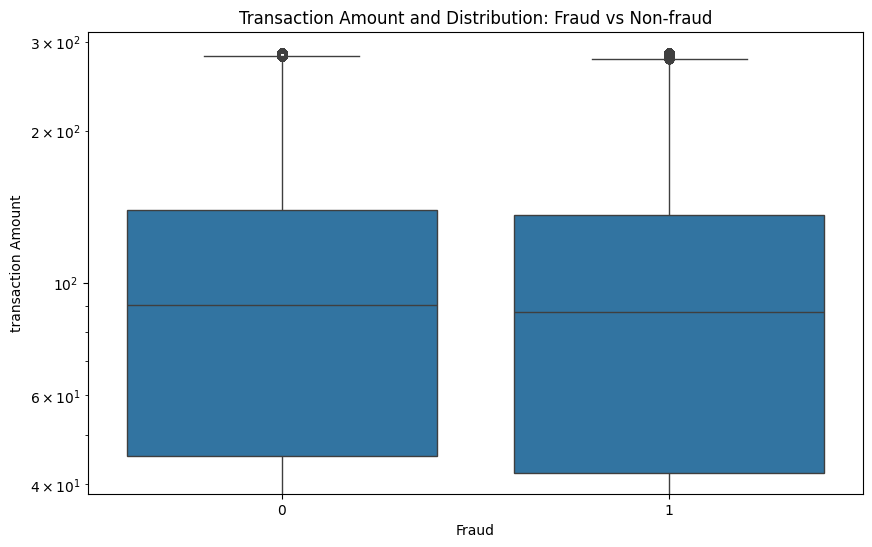

In [35]:
#EDA analysis on amount vs fraud_risk
#Used boxplot to differentiate between different quantiles for each potential fraud transactions and Non-fraud transactions.
plt.figure(figsize=(10, 6))
sb.boxplot(x='fraud_risk', y = 'trans_amount', data = df)
plt.yscale('log')
plt.title('Transaction Amount and Distribution: Fraud vs Non-fraud')
plt.ylabel('transaction Amount')
plt.xlabel('Fraud')
plt.show()

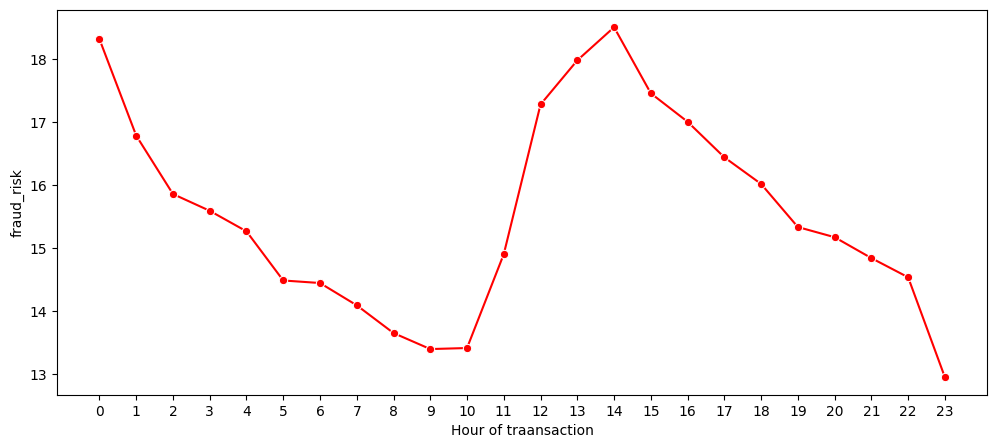

In [36]:
#fraud_risk vs transaction hour
hourly_fraud = df.groupby('trans_hour')['fraud_risk'].mean() * 100
plt.figure(figsize= (12, 5))
sb.lineplot(x = hourly_fraud.index, y=hourly_fraud.values, marker='o', color='red')
plt.xlabel('Hour of traansaction')
plt.ylabel('fraud_risk')
plt.xticks(range(0,24))
plt.show()

In [34]:
#most of the fraud risked transaction takes place at around 12 midnight or at 3-4pm.

In [ ]:
"""
*The dataset has been taken from kaggle, using kagglehub. It contains around 5,00,000 entries of data. the data contains 11 columns. The dataset is distinguishing all the transsacrtions into fraud transactions and safe transactions. The dataset is imbalanced. 
*Dataset takes into account the, transaction time and upi numbers.
* I have compared the fraud_transaction count vs safe transaction counts. Also does correlation matrix between features. 
* I have compared between hour of transaction and fraud_risk. & boxplot to find the distribution of quartets of amount for fraud_risk=1 and fraud_risk=0.
* It has seaborn heatmap plots also.  
"""